In [42]:
import pandas as pd
import numpy as np
import sqlite3
import gspread
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%load_ext sql
%matplotlib inline

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [43]:
#First find the from and to date to encompass entire dataset
conn = sqlite3.connect('/Users/alvinyu/MFE_Preprogram/UCB-MFE-python-preprogram/Lectures/Lecture 4/data/data.db')
curr = conn.cursor()
curr.execute("SELECT * FROM ohlc")
data = curr.fetchall()
database_dataframe=pd.DataFrame(data,columns=['ts','open','high','low','close','volume','volumeUSD','token','chain'])
database_dataframe.set_index('ts',inplace=True)
conn.close()
database_dataframe.loc[database_dataframe.token=='BTC']
#shows start time is 2021-11-01 00:00:00 and end time is 2021-12-15 00:00:00

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC
2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC
2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC
2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC
2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC
...,...,...,...,...,...,...,...,...
2021-12-14 20:00:00,46658.23,47086.98,46649.03,46877.70,783.748050,3.677161e+07,BTC,BTC
2021-12-14 21:00:00,46875.95,47890.62,46856.37,47805.73,1634.610294,7.759534e+07,BTC,BTC
2021-12-14 22:00:00,47805.73,48686.91,47773.01,48303.57,1804.082095,8.714276e+07,BTC,BTC


In [44]:
#function to calculate hourly return
def hourly_return(df):
    return np.log(df.close/df.close.shift(1))

In [45]:
#function to calculate hourly volatility(used from lecture notes)
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [46]:
#function to calculate hourly drawdown
def maximum_drawdown(df):
    cummulative_max_close= df.close.cummax()
    draw_down = (df.close - cummulative_max_close)/df.close
    #because these values are negative, to get the maximum drawdown, we will use cummulative min function, which wors as draw_down is a dataframe
    maximum_drawdown = draw_down.cummin()
    return maximum_drawdown

In [47]:
#function to plot(borrowed from lectue, with the events section removed)
def series_plot(data, events=None, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)


In [48]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-11'
connection_string = connection_string = 'sqlite:///../../../Lectures/Lecture 4/data/data.db'

In [49]:
#borrowed from lecture
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)



In [50]:
prices['volatility'] = vol_ohlc(prices)
prices['max_draw_down']=maximum_drawdown(prices)
prices['hourly_return']=hourly_return(prices)

prices

,open,high,low,close,volume,volumeUSD,token,chain,volatility,max_draw_down,hourly_return
ts,,,,,,,,,,,
2021-11-05 00:00:00,61188.45,61531.65,61140.22,61444.50,232.054183,1.423677e+07,BTC,BTC,NaN,0.000000,NaN
2021-11-05 01:00:00,61444.49,61537.09,60870.00,60920.77,343.899671,2.105516e+07,BTC,BTC,NaN,-0.008597,-0.008560
2021-11-05 02:00:00,60920.68,61840.00,60896.37,61820.72,387.049829,2.374667e+07,BTC,BTC,NaN,-0.008597,0.014664
2021-11-05 03:00:00,61820.72,61960.00,61678.53,61678.53,370.385830,2.290663e+07,BTC,BTC,NaN,-0.008597,-0.002303
2021-11-05 04:00:00,61678.53,62364.98,61678.53,62247.05,424.671468,2.637991e+07,BTC,BTC,NaN,-0.008597,0.009175
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10 19:00:00,68638.47,68656.48,67592.06,67782.03,972.965320,6.622890e+07,BTC,BTC,0.127073,-0.032800,-0.012573
2021-11-10 20:00:00,67781.42,68010.62,66559.37,66640.96,1006.991010,6.783128e+07,BTC,BTC,0.138592,-0.032800,-0.016978
2021-11-10 21:00:00,66640.96,67041.51,65100.00,65835.00,2119.548755,1.404769e+08,BTC,BTC,0.167518,-0.042601,-0.012168


In [51]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))


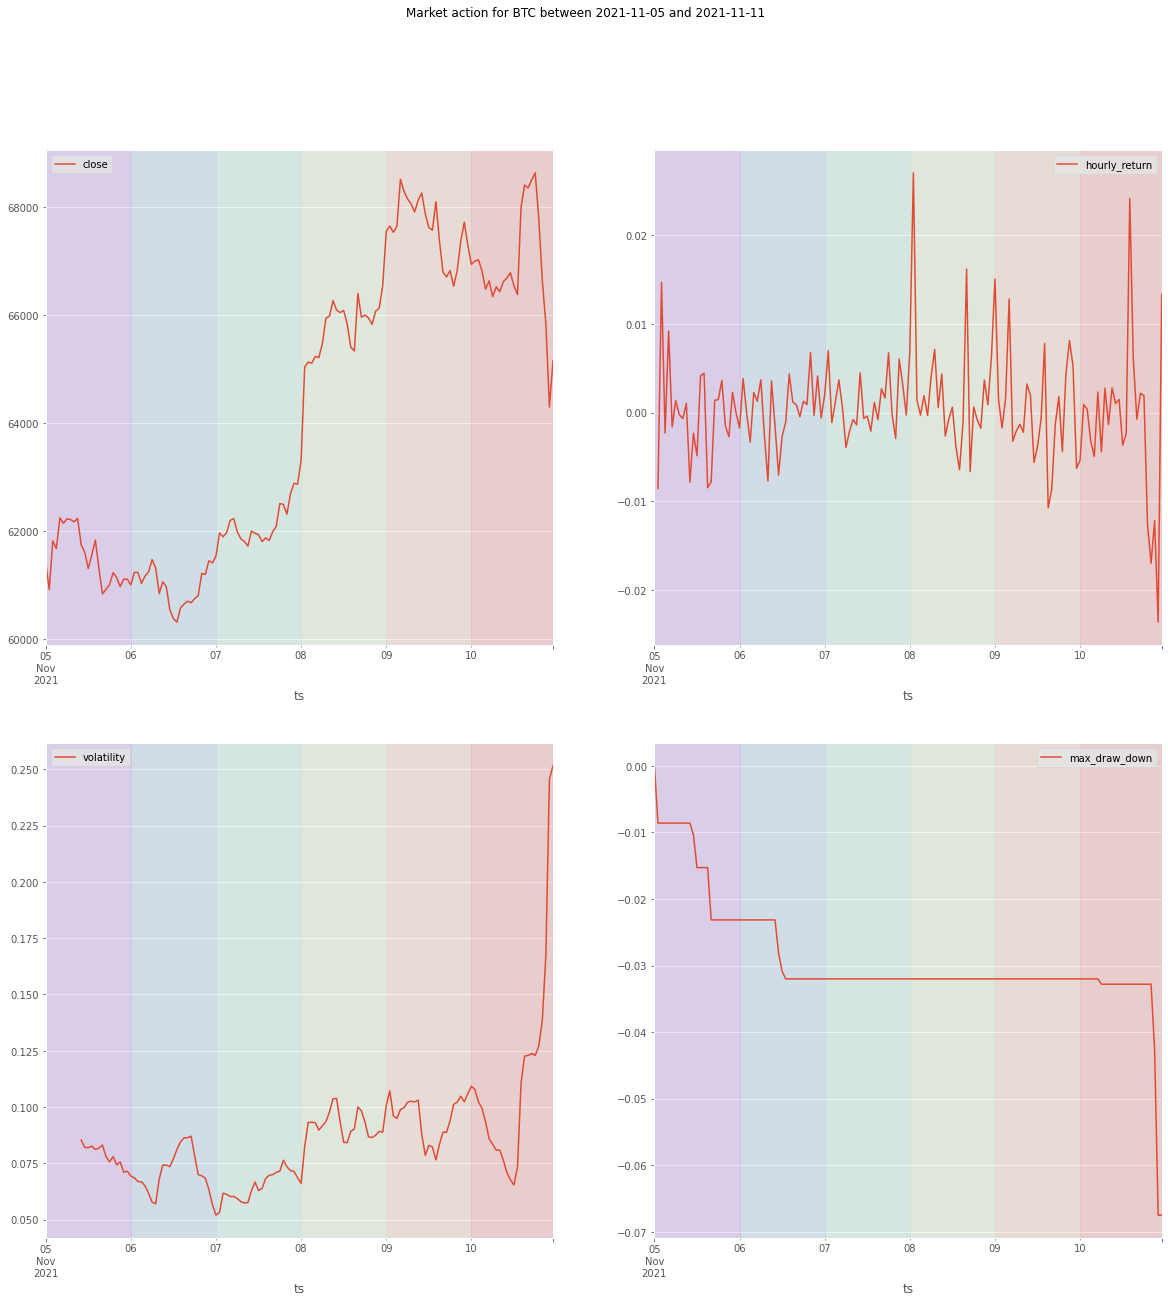

In [52]:
series_plot(prices[['close']],ax=ax[0, 0])
series_plot(prices[['hourly_return']],ax=ax[0, 1])
series_plot(prices[['volatility']], ax=ax[1, 0])
series_plot(prices[['max_draw_down']], ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

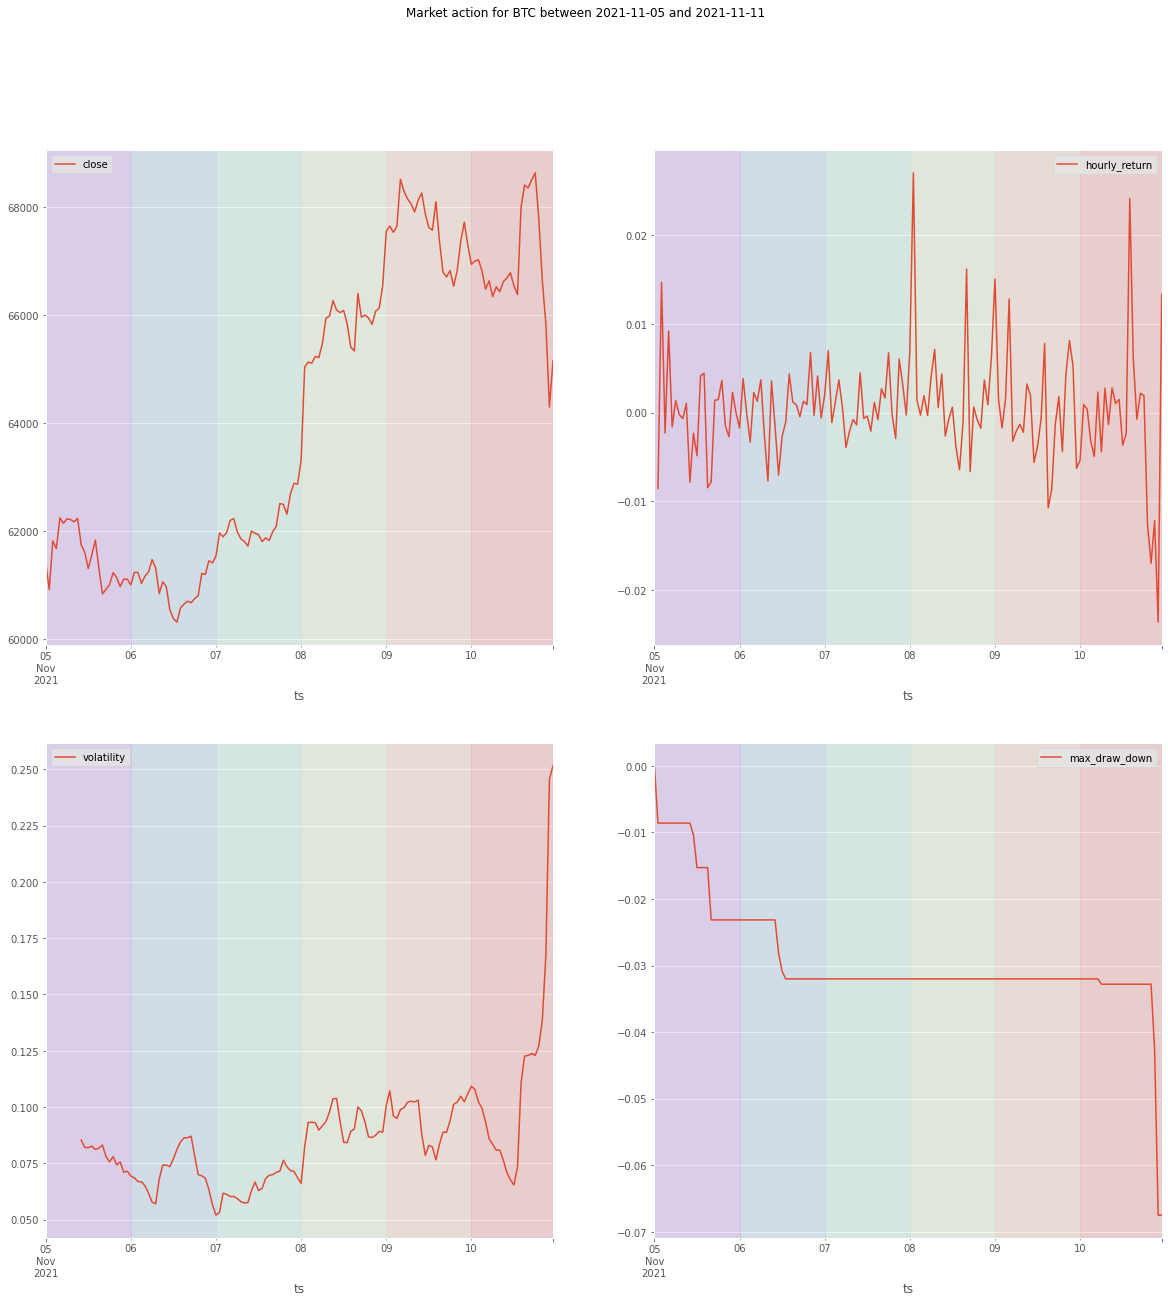

In [53]:
#gluing borrowed from lecture
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)